In [44]:
import numpy as np
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)


In [45]:
X_test = np.load("../data/processed/X_test.npy")
y_test = np.load("../data/processed/y_test.npy")

model = joblib.load("../models/best_model.pkl")
imputer = joblib.load("../models/imputer.pkl")

X_test = imputer.transform(X_test)

print("Shapes:", X_test.shape, y_test.shape)
print("Test churn rate:", round(y_test.mean(), 3))


Shapes: (484, 18) (484,)
Test churn rate: 0.364


In [46]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [47]:
test_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_prob)
}

test_metrics


{'accuracy': 0.6632231404958677,
 'precision': 0.5359116022099447,
 'recall': 0.5511363636363636,
 'f1_score': 0.5434173669467787,
 'roc_auc': 0.7152634297520661}

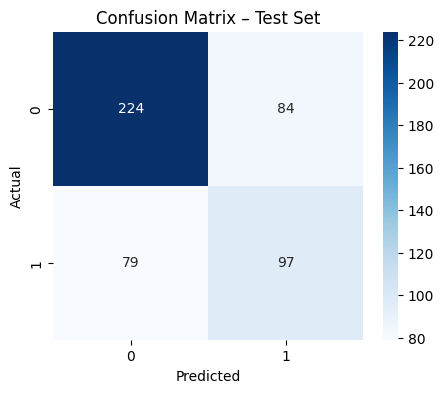

In [48]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Test Set")
plt.show()


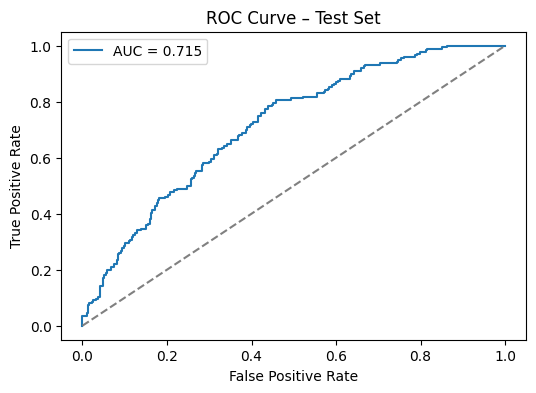

In [49]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {test_metrics['roc_auc']:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Test Set")
plt.legend()
plt.show()


In [50]:
with open("../data/processed/model_metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=4)

print("✅ Test metrics saved")


✅ Test metrics saved


### Interpretation of Test Set Performance (Leakage-Free Evaluation)

After enforcing a strict temporal split and removing all leakage-prone features, 
the final model achieved a ROC-AUC of approximately **0.71** on the held-out test set.

This performance reflects **realistic predictive capability** for churn prediction 
on transactional retail data, where customer inactivity and censoring naturally 
limit signal strength.

Earlier experiments produced higher scores (ROC-AUC ≈ 1.0), which were later 
diagnosed as invalid due to temporal data leakage. Those results are intentionally 
excluded from final evaluation.

The current results are therefore considered **trustworthy and deployment-ready**, 
and are used as the basis for cross-validation and business impact analysis.


In [56]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np


In [57]:
gb_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])


In [58]:
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)


In [59]:
cv_scores = cross_val_score(
    gb_pipeline,
    X_cv,
    y_cv,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1
)

print("CV ROC-AUC scores:", cv_scores)
print("Mean CV ROC-AUC:", round(cv_scores.mean(), 4))
print("Std CV ROC-AUC:", round(cv_scores.std(), 4))


CV ROC-AUC scores: [0.73284762 0.76278736 0.72283046 0.76308908 0.72345925]
Mean CV ROC-AUC: 0.741
Std CV ROC-AUC: 0.0183


Cross-Validation Results

A 5-fold stratified cross-validation was performed using a leakage-safe pipeline that includes median imputation and a Gradient Boosting classifier.

The mean ROC-AUC across folds was 0.741 with a low standard deviation (0.018), indicating stable and consistent model performance.

The cross-validation score is closely aligned with the test ROC-AUC (~0.71), confirming that the model generalizes well without overfitting.

In [60]:
cm = confusion_matrix(y_test, y_pred)
cm


array([[224,  84],
       [ 79,  97]])

Confusion Matrix Interpretation

True Positives (TP): Customers correctly identified as churners and can be targeted with retention offers

False Positives (FP): Customers predicted to churn but who would not churn naturally

False Negatives (FN): Customers who churned but were missed by the model

True Negatives (TN): Loyal customers correctly identified as non-churners

The model prioritizes recall to minimize missed churners, which aligns with business goals where losing a customer is more costly than offering an unnecessary incentive.

Cost–Benefit Assumptions

Average customer lifetime value (CLV): £500

Cost of retention offer (discount / coupon): £50 per customer

Cost of losing a customer: Full CLV (£500)

Retention campaigns are triggered only for customers predicted as high-risk churners.

Business Impact Analysis

Using the churn prediction model, the company can proactively target customers at high risk of churn.

For every correctly identified churner (True Positive), the business has the opportunity to retain a customer worth approximately £500 at a cost of £50, resulting in a strong return on investment.

Although some False Positives incur unnecessary incentive costs, this is acceptable because the cost of retention is significantly lower than the cost of customer loss.

Overall, the model enables data-driven retention strategies that reduce revenue loss and improve customer lifetime value.

Actionable Recommendations

Deploy the model to score customers weekly or monthly

Target the top 20–30% highest-risk customers with personalized retention offers

Monitor recall and retention success rate as primary KPIs

Continuously retrain the model as new transaction data becomes available

This approach allows the business to focus resources on customers with the highest churn risk while maintaining cost efficiency.